In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [2]:
#Считываем данные
df = pd.read_csv('https://stepik.org/media/attachments/lesson/396012/hw_aa.csv', sep=';', index_col=0)

In [3]:
#Данные для А/А теста
df.query('experimentVariant == 1').purchase
df.query('experimentVariant == 0').purchase

2         0
7         0
9         0
12        0
17        0
         ..
127009    0
127012    0
127013    0
127014    0
127015    0
Name: purchase, Length: 63102, dtype: int64

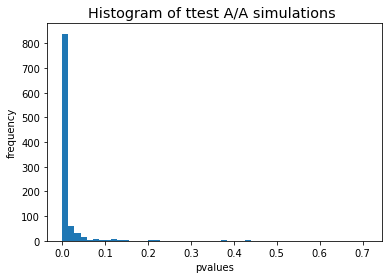

0.936

In [4]:
n = 100000
simulations = 1000
n_s = 1000
res = []


# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df.query('experimentVariant == 1').purchase.sample(n_s, replace = False).values
    s2 = df.query('experimentVariant == 0').purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Получаем FPR > альфа (более 0.9), что означает что в больше чем в 90% случаев мы получаем статистически значимую разницу в конверсии в двух экспериментальных группах (чего быть не должно).

In [5]:
# Смотрим на конверсии в разных группах и разных версиях
df.groupby(['experimentVariant', 'version']).agg({'purchase' : 'mean'})

purchase
experimentVariant version           
0                 v2.8.0    0.000993
                  v2.9.0    0.074658
                  v3.7.4.0  0.059943
                  v3.8.0.0  0.057604
1                 v2.8.0    0.045606
                  v2.9.0    0.071304
                  v3.7.4.0  0.063018
                  v3.8.0.0  0.062848

В данной таблице видно, что очень выбивается версия v2.8.0 в группе 0. Найдем значение p-value для каждой версии (если p-value < 0.05, значит есть статистически значимые различия между пользователями данной версии в двух группах)

In [6]:
# version v2.8.0
stats.ttest_ind(df[(df.version == "v2.8.0") & (df.experimentVariant == 1)]['purchase'], 
               df[(df.version == "v2.8.0") & (df.experimentVariant == 0)]['purchase'])

Ttest_indResult(statistic=42.963540840360324, pvalue=0.0)

In [7]:
# version v2.9.0
stats.ttest_ind(df[(df.version == "v2.9.0") & (df.experimentVariant == 1)]['purchase'], 
               df[(df.version == "v2.9.0") & (df.experimentVariant == 0)]['purchase'])

Ttest_indResult(statistic=-0.9979597634962479, pvalue=0.31830895167207446)

In [8]:
# version v3.7.4.0
stats.ttest_ind(df[(df.version == "v3.7.4.0") & (df.experimentVariant == 1)]['purchase'], 
               df[(df.version == "v3.7.4.0") & (df.experimentVariant == 0)]['purchase'])

Ttest_indResult(statistic=0.5874925850487471, pvalue=0.5568886771079735)

In [9]:
# version v3.8.0.0
stats.ttest_ind(df[(df.version == "v3.8.0.0") & (df.experimentVariant == 1)]['purchase'], 
               df[(df.version == "v3.8.0.0") & (df.experimentVariant == 0)]['purchase'])

Ttest_indResult(statistic=1.1956188950206779, pvalue=0.23186933664059722)

Мы видим, что только для версии v2.8.0 p-value < 0.05. Попробуем убрать эту версию из обеих групп и провести заново А/А тест.

In [10]:
# Данные для А/А теста
df[(df.experimentVariant == 1) & (df.version != 'v2.8.0')]['purchase']
df[(df.experimentVariant == 0) & (df.version != 'v2.8.0')]['purchase']

2         0
7         0
18        0
34        1
39        1
         ..
126993    0
126994    0
126995    0
126997    0
127003    0
Name: purchase, Length: 21819, dtype: int64

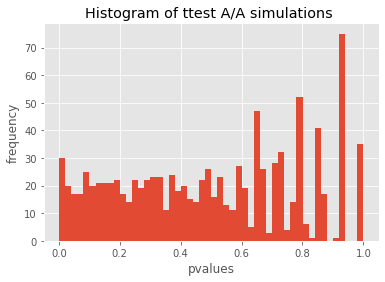

0.059

In [11]:
n = 100000
simulations = 1000
n_s = 1000
res = []


# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[(df.experimentVariant == 1) & (df.version != 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    s2 = df[(df.experimentVariant == 0) & (df.version != 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Получили значение FPR < альфа, что меньше альфа. Значит, мы нашли поломку.

Выводы:
При анализе изначальных данных с помощью А/А теста было выявлено, что между данными есть статистические различия и провободить в последствии A/B тестирование на таких группах было бы не целесообразно. 
С помощью анализа была выявлена проблема - версия v2.8.0 (значимое различие конверсии между двумя группами, p-value < 0.05). Исключив эту версию в обоих группах и проведя новый А/А тест, мы получили нужный результат (FPR < альфа). Теперь на этих группах можно проводить A/B тест, так как они мало различаются между собой.